# 서울 부동산 시장 분석 및 투자 전략 수립

## 과제 3: 부동산 거래량과 가격의 선행지표 관계 분석
부동산 거래량 변화가 가격 변동에 미치는 영향을 시차 분석을 통해 파악하고, 시장 전환점을 예측할 수 있는 지표를 개발

- 월별 부동산 거래량 변화 확인
- 시장 전환점 예측(변곡점, 극대값, 극소값 등) 지표 개발

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display

warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

df_sales = pd.read_csv('./data/sales_clean.csv')
df_sales['계약월'] = pd.to_datetime(df_sales['계약월'], format='%Y-%m-%d')

In [17]:
monthly_stats = df_sales.groupby(['계약월']).agg({
    '거래금액': ['count', 'mean'],
    '평단가': 'mean'
}).reset_index()
monthly_stats.columns = ['계약월', '월별거래건수', '월평균거래금액', '월평균평단가']

# 월별 거래량, 평단가 변화율 계산
monthly_stats['월별거래량변화율'] = monthly_stats['월별거래건수'].pct_change()
monthly_stats['월별평단가변화율'] = monthly_stats['월평균평단가'].pct_change()

# 이동평균 / 이동표준편차
monthly_stats['이동평균'] = monthly_stats['월평균거래금액'].rolling(12, min_periods=1).mean()
monthly_stats['이동표준편차'] = monthly_stats['월평균거래금액'].rolling(12, min_periods=1).std()

최적 시차 (거래량 → 가격 변화):
Lag(개월)    0.000000
상관계수       0.499444
Name: 0, dtype: float64


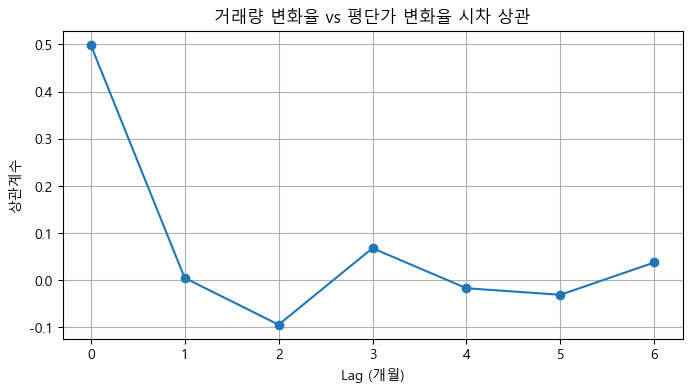

In [24]:
max_lag = 6
lag_corr = {}

for lag in range(0, max_lag+1):
    lag_corr[lag] = monthly_stats['월별거래량변화율'].shift(lag).corr(monthly_stats['월별평단가변화율'])

# 결과 확인
lag_corr_df = pd.DataFrame(list(lag_corr.items()), columns=['Lag(개월)', '상관계수'])

best_lag = lag_corr_df.loc[lag_corr_df['상관계수'].idxmax()]
print("최적 시차 (거래량 → 가격 변화):")
print(best_lag)

plt.figure(figsize=(8,4))
plt.plot(lag_corr_df['Lag(개월)'], lag_corr_df['상관계수'], marker='o')
plt.title('거래량 변화율 vs 평단가 변화율 시차 상관')
plt.xlabel('Lag (개월)')
plt.ylabel('상관계수')
plt.grid(True)
plt.show()

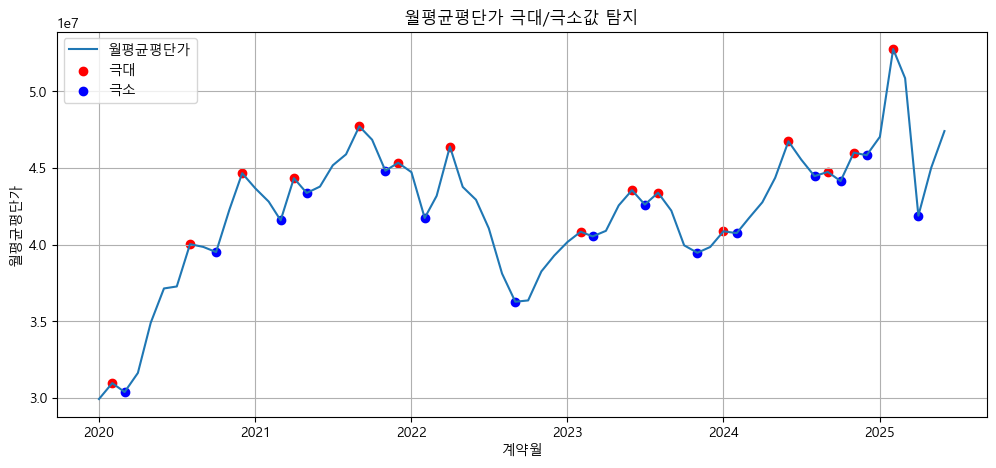

In [46]:
# 극대/극소값 탐지 함수
def detect_extrema(series):
    maxima = (series.shift(1) < series) & (series.shift(-1) < series)
    minima = (series.shift(1) > series) & (series.shift(-1) > series)
    return maxima, minima

# 월별평단가를 기준으로 탐지
monthly_stats['극대'], monthly_stats['극소'] = detect_extrema(monthly_stats['월평균평단가'])

# 결과 확인
plt.figure(figsize=(12,5))
plt.plot(monthly_stats['계약월'], monthly_stats['월평균평단가'], label='월평균평단가')
plt.scatter(monthly_stats['계약월'][monthly_stats['극대']], 
            monthly_stats['월평균평단가'][monthly_stats['극대']], color='red', label='극대')
plt.scatter(monthly_stats['계약월'][monthly_stats['극소']], 
            monthly_stats['월평균평단가'][monthly_stats['극소']], color='blue', label='극소')
plt.title('월평균평단가 극대/극소값 탐지')
plt.xlabel('계약월')
plt.ylabel('월평균평단가')
plt.legend()
plt.grid(True)
plt.show()


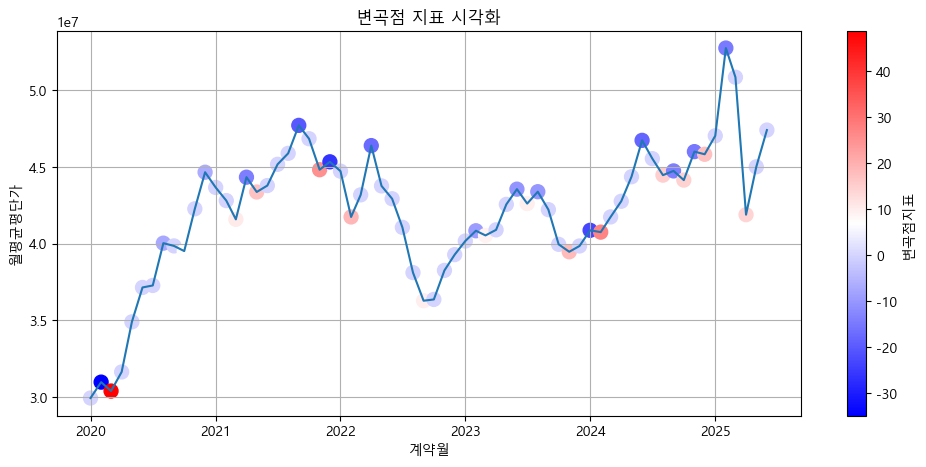

In [48]:
# 거래량 변화율 z-score 계산
monthly_stats['거래량변화_z'] = (monthly_stats['월별거래량변화율'] - monthly_stats['이동평균']) / monthly_stats['이동표준편차']

# 극대/극소값에 가중치 부여
monthly_stats['변곡점지표'] = 0
monthly_stats.loc[monthly_stats['극대'], '변곡점지표'] = monthly_stats['거래량변화_z']
monthly_stats.loc[monthly_stats['극소'], '변곡점지표'] = -monthly_stats['거래량변화_z']

# 결과 확인
plt.figure(figsize=(12,5))
plt.plot(monthly_stats['계약월'], monthly_stats['월평균평단가'], label='월평균평단가')
plt.scatter(monthly_stats['계약월'], monthly_stats['월평균평단가'], 
            c=monthly_stats['변곡점지표'], cmap='bwr', label='변곡점지표', s=100)
plt.colorbar(label='변곡점지표')
plt.title('변곡점 지표 시각화')
plt.xlabel('계약월')
plt.ylabel('월평균평단가')
plt.grid(True)
plt.show()

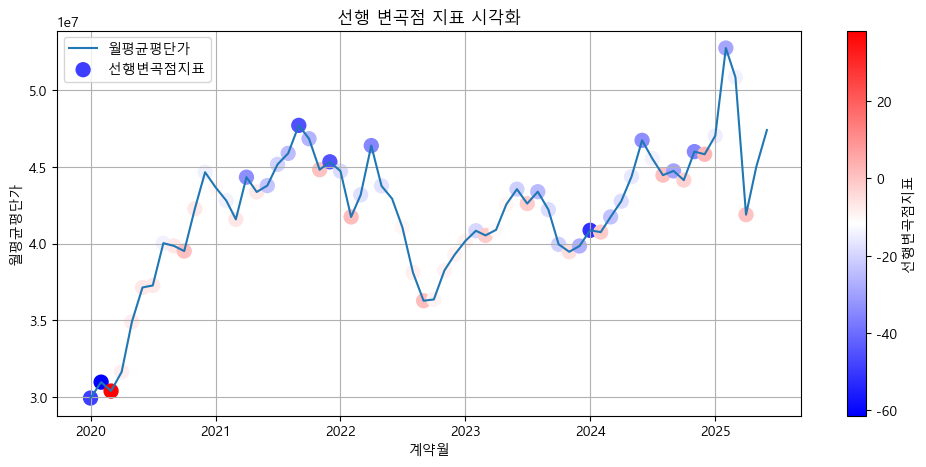

In [49]:
# 거래량 변화율 z-score 계산 (이미 있음)
monthly_stats['거래량변화_z'] = (monthly_stats['월별거래량변화율'] - monthly_stats['이동평균']) / monthly_stats['이동표준편차']

# 선행 신호: 거래량 변화를 앞당겨 반영 (예: 2개월 선행)
lead_months = 2
monthly_stats['선행거래량지표'] = monthly_stats['거래량변화_z'].shift(-lead_months)

# 최종 선행 지표 = 기존 변곡점지표 + 선행 거래량 지표
monthly_stats['선행변곡점지표'] = monthly_stats['변곡점지표'] + monthly_stats['선행거래량지표']

plt.figure(figsize=(12,5))
plt.plot(monthly_stats['계약월'], monthly_stats['월평균평단가'], label='월평균평단가')
plt.scatter(monthly_stats['계약월'], monthly_stats['월평균평단가'], 
            c=monthly_stats['선행변곡점지표'], cmap='bwr', s=100, label='선행변곡점지표')
plt.colorbar(label='선행변곡점지표')
plt.title('선행 변곡점 지표 시각화')
plt.xlabel('계약월')
plt.ylabel('월평균평단가')
plt.grid(True)
plt.legend()
plt.show()

In [53]:
from sklearn.model_selection import TimeSeriesSplit

# -------------------------------
# 파라미터
# -------------------------------
lead_months = 2   # 거래량 선행 개월 수
L = 3             # 실제 전환이 몇 개월 내에 나타나야 "적중"으로 볼지
tau_candidates = np.arange(1.0, 2.6, 0.25)  # 신호 민감도 후보
n_splits = 5      # TimeSeriesSplit 구간 수
# -------------------------------

# 1) 선행 변곡점 지표 만들기
monthly_stats['거래량변화_z'] = (monthly_stats['월별거래량변화율'] - monthly_stats['이동평균']) / monthly_stats['이동표준편차']
monthly_stats['선행거래량지표'] = monthly_stats['거래량변화_z'].shift(-lead_months)
monthly_stats['선행변곡점지표'] = monthly_stats['변곡점지표'] + monthly_stats['선행거래량지표']

# 2) 전환 라벨 만들기 (L개월 내 extremum 확인)
def label_turning_points(df, L=3):
    price = df['월평균평단가']
    is_max = (price.shift(1) < price) & (price.shift(-1) < price)
    is_min = (price.shift(1) > price) & (price.shift(-1) > price)
    df['turn_up'] = is_min.astype(int)
    df['turn_dn'] = is_max.astype(int)
    df['y_up'] = df['turn_up'].rolling(L, min_periods=1).max().shift(-0).fillna(0).astype(int)
    df['y_dn'] = df['turn_dn'].rolling(L, min_periods=1).max().shift(-0).fillna(0).astype(int)
    return df

df = monthly_stats.copy()
df = label_turning_points(df, L=L)

# 3) 신호 생성
def make_signals(df, tau=1.5):
    sig_up = (df['선행변곡점지표'] >  tau).astype(int)
    sig_dn = (df['선행변곡점지표'] < -tau).astype(int)
    return sig_up, sig_dn

# 4) 평가 함수
def evaluate(sig, label):
    tp = ((sig==1) & (label==1)).sum()
    fp = ((sig==1) & (label==0)).sum()
    fn = ((sig==0) & (label==1)).sum()
    precision = tp / (tp+fp) if (tp+fp)>0 else 0
    recall    = tp / (tp+fn) if (tp+fn)>0 else 0
    f1        = 2*precision*recall/(precision+recall) if (precision+recall)>0 else 0
    return precision, recall, f1

# 5) Walk-forward 검증
tscv = TimeSeriesSplit(n_splits=n_splits)
results = []

for train_idx, test_idx in tscv.split(df):
    tr, te = df.iloc[train_idx].copy(), df.iloc[test_idx].copy()
    
    # τ 최적화 (학습 구간에서 F1 합계 최대)
    best = (-1, -1, -1)
    for tau in tau_candidates:
        s_up, s_dn = make_signals(tr, tau)
        p_up, r_up, f1_up = evaluate(s_up, tr['y_up'])
        p_dn, r_dn, f1_dn = evaluate(s_dn, tr['y_dn'])
        score = f1_up + f1_dn
        if score > best[0]:
            best = (score, tau, (f1_up, f1_dn))
    tau_star = best[1]

    # 테스트 구간 평가
    su, sd = make_signals(te, tau_star)
    p_up, r_up, f1_up = evaluate(su, te['y_up'])
    p_dn, r_dn, f1_dn = evaluate(sd, te['y_dn'])
    
    results.append({
        'tau': tau_star,
        'precision_up': p_up, 'recall_up': r_up, 'f1_up': f1_up,
        'precision_dn': p_dn, 'recall_dn': r_dn, 'f1_dn': f1_dn
    })

perf = pd.DataFrame(results)
print("검증 결과:")
print(perf)
print("\n평균 성능:")
print(perf.mean(numeric_only=True))

검증 결과:
   tau  precision_up  recall_up     f1_up  precision_dn  recall_dn     f1_dn
0  1.0           0.0   0.000000  0.000000      0.727273   1.000000  0.842105
1  1.0           1.0   0.285714  0.444444      0.625000   0.714286  0.666667
2  1.0           0.0   0.000000  0.000000      0.545455   1.000000  0.705882
3  1.0           0.0   0.000000  0.000000      0.636364   1.000000  0.777778
4  1.0           1.0   0.100000  0.181818      1.000000   0.666667  0.800000

평균 성능:
tau             1.000000
precision_up    0.400000
recall_up       0.077143
f1_up           0.125253
precision_dn    0.706818
recall_dn       0.876190
f1_dn           0.758486
dtype: float64
